In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from math import ceil

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Functions

## Creating activity df

In [ ]:
def create_activities_df(path):
    """ A function for creating a dataframe containing information about the beginning, end and name of each physical activity
    Args:
        1) path - the path to the Label Studio file that contains the labeled signals
    Returns:
        Dataframe containing information about the beginning, end and name of each physical activity
    """
    labeled_activities = pd.read_csv(path)
    labels = labeled_activities['label']
    labels = np.array(labels)[0]    # the original type of labels is pd.Series
    labels = labels.split('},')
    
    activities_dict = {'start_time': [], 'end_time': [], 'activity': []}
    for label in labels:
        start_time, end_time, _, activity = label.split(',')
        activities_dict['start_time'].append(float(start_time.split(':')[1]))
        activities_dict['end_time'].append(float(end_time.split(':')[1]))
        activities_dict['activity'].append(activity.split(':')[1].strip('[]}"'))
    
    activities_df = pd.DataFrame.from_dict(activities_dict)
    activities_df = activities_df.sort_values(by='start_time').reset_index(drop=True)
    return activities_df

def add_activity_column(path, df, df_merge_col):
    """ Function to add 'activity' column to dataframe df
    Args:
        1) path - the path to the Label Studio file that contains the labeled signals
        2) df - a dataframe that contains the results of accelerometer and gyroscope measurements
        3) df_merge_col - the name of the column of the dataframe df, which contains data about the measurement time ('time' column)
    """
    activities_df_local = create_activities_df(path)
    merged_df = pd.merge_asof(df, activities_df_local, left_on=df_merge_col, right_on='start_time', direction='backward')
    df['activity'] = merged_df['activity']
    
    
def display_activity_freq_spectrum_one_axes(df, activity_name, axes_name, sampling_rate, is_divided_by_g=False, x_lim=10, color='blue'):
    """ Function to display the frequency spectrum of the specified type of activity on the OX, OY and OZ axes for the specified device 
    (accelerometer or gyroscope)
    Args:
        1) df - a dataframe that contains the results of accelerometer and gyroscope measurements
        2) activity_name - selected activity type (among the values of the 'activity' column of df)
        3) axes_name - the column name of the dataframe df that contain the measurement results for the OX, OY, or OZ axes
        4) sampling_rate - actual sampling rate of your dataset (samples per second)
        5) is_divided_by_g - True if the content of the column was divided by the free fall acceleration g (g=9.81 m/s^2)
        6) x_lim - the limits of the graph along the OX axis are [-x_lim; x_lim]
        7) color - the color of the graph
    """
    activity_data = df[df['activity'] == activity_name]
    
    signal = np.array(activity_data[axes_name])
    
    if is_divided_by_g:
        signal *= 9.81
        
    fft_result = fft(signal)

    fft_freqs = fftfreq(len(activity_data), 1/sampling_rate)

    fig = plt.figure(figsize=(12, 5))
    axes = fig.add_axes([0.1, 0.1, 1, 1])
    axes.plot(fft_freqs, np.abs(fft_result), color=color)
    axes.set_title(f'{activity_name} {axes_name}')

    axes.set_xlabel('Frequency (Hz)')
    axes.set_xlim(-x_lim, x_lim)
    axes.set_ylabel('Amplitude')
    axes.grid(alpha=0.5)

    plt.show()

    
def display_activity_freq_spectrum(df, activity_name, axes_names, sampling_rate, is_divided_by_g=False, x_lim=10):
    """ Function to display the frequency spectrum of the specified type of activity on the OX, OY and OZ axes for the specified device 
    (accelerometer or gyroscope)
    Args:
        1) df - a dataframe that contains the results of accelerometer and gyroscope measurements
        2) activity_name - selected activity type (among the values of the 'activity' column of df)
        3) axes_names - an array containing the column names of the dataframe df that contain the measurement results for the OX, OY, and OZ axes, 
        respectively
        4) sampling_rate - actual sampling rate of your dataset (samples per second)
        5) is_divided_by_g - True if the content of the column was divided by the free fall acceleration g (g=9.81 m/s^2)
        6) x_lim - the limits of the graph along the OX axis are [-x_lim; x_lim]
    """
    activity_data = df[df['activity'] == activity_name]
    
    signal_x = np.array(activity_data[axes_names[0]])
    signal_y = np.array(activity_data[axes_names[1]])
    signal_z = np.array(activity_data[axes_names[2]])
    
    if is_divided_by_g:
        signal_x *= 9.81
        signal_y *= 9.81
        signal_z *= 9.81
        
    fft_x = fft(signal_x)
    fft_y = fft(signal_y)
    fft_z = fft(signal_z)

    fft_freqs = fftfreq(len(activity_data), 1/sampling_rate)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].plot(fft_freqs, np.abs(fft_x), label='X', color='blue')
    axes[0].set_title(f'{activity_name} {axes_names[0]}')

    axes[1].plot(fft_freqs, np.abs(fft_y), label='Y', color='yellow')
    axes[1].set_title(f'{activity_name} {axes_names[1]}')

    axes[2].plot(fft_freqs, np.abs(fft_z), label='Z', color='green')
    axes[2].set_title(f'{activity_name} {axes_names[2]}')

    for ax in axes:
        ax.set_xlabel('Frequency (Hz)')
        ax.set_xlim(-x_lim, x_lim)
        ax.set_xticks([i for i in range(-x_lim, x_lim+1, 2)])
        ax.set_ylabel('Amplitude')
        ax.grid(alpha=0.5)
        ax.legend()

    plt.tight_layout()
    plt.show()

## Visualizing results

In [ ]:
def display_three_axes(df, x, y, title=None, x_label=None, y_label=None):
    """ Function for visualization of three axes (X, Y, Z) of the measurement results of the device
    Args:
        1) df - a dataframe containing the results of the device measurement;
        2) x - the name of the column of the dataframe that contains the data for the OX axis (for the three lines, this is the same data);
        3) y - the list containing the dataframe column names corresponding to the OX, OY, and OZ axis measurements, respectively;
        4) title - title of the graph;
        5) x_label - the name of the OX axis of the graph;
        6) y_label - the name of the OY axis of the graph.
    Returns:
        Nothing, but plots graph
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df[x], df[y[0]], label='X')
    plt.plot(df[x], df[y[1]], label='Y')
    plt.plot(df[x], df[y[2]], label='Z')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.savefig(f'graphs/{title}.png', bbox_inches='tight')
    plt.show()
    

def display_three_axes_sep(df, x, y, title=None, x_label=None, y_labels=None):
    """ Function for visualization of three axes (X, Y, Z) of the measurement results of the device, a separate graph for each axis
    Args:
        1) df - a dataframe containing the results of the device measurement;
        2) x - the name of the column of the dataframe that contains the data for the OX axis (for the three lines, this is the same data);
        3) y - the list containing the dataframe column names corresponding to the OX, OY, and OZ axis measurements, respectively;
        4) title - title of the graph;
        5) x_label - the name of the OX axis of the graph;
        6) y_labels - the list of names of the OY axis of the graph.
    Returns:
        Nothing, but plots graph
    """
    fig, axes = plt.subplots(3, 1, figsize=(10, 18))
    axes[0].plot(df[x], df[y[0]], color='blue')
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel(y_labels[0])
    axes[0].set_title(title + ' accX')

    axes[1].plot(df[x], df[y[1]], color='yellow')
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel(y_labels[1])
    axes[1].set_title(title + ' accY')

    axes[2].plot(df[x], df[y[2]], color='green')
    axes[2].set_xlabel(x_label)
    axes[2].set_ylabel(y_labels[2])
    axes[2].set_title(title + ' accZ')

    plt.show()

## Windowing

In [ ]:
def windowed_pie_chart(original_df, windowed_df, column, first_chart_title='Original DataFrame', second_chart_title='Windowed DataFrame'):
    """Function for displaying the ratio of column content between the original dataframe and the windowed dataframe in the form of a pie chart
    Args:
        1) original_df - the original dataframe that contains the required information;
        2) windowed_df - a dataframe that contains the results of windowing;
        3) column - the name of the dataframe column whose percentage values are to be found.
    Returns:
        None; just builds a pie chart to display the ratio of column contents between the original dataframe and the windowed dataframe
    """
    # Calculate the percentage of each activity in original_df
    activity_percentages_df = original_df[column].value_counts(normalize=True) * 100

    # Calculate the percentage of each activity in windowed_df
    activity_percentages_windowed = windowed_df[column].value_counts(normalize=True) * 100

    # Create subplots for pie charts
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot pie chart for df
    sns.set_palette("Set3")
    axes[0].pie(activity_percentages_df, labels=activity_percentages_df.index, autopct='%1.1f%%', startangle=140)
    axes[0].set_title(first_chart_title)

    # Plot pie chart for windowed_df
    sns.set_palette("Set3")
    axes[1].pie(activity_percentages_windowed, labels=activity_percentages_df.index, autopct='%1.1f%%', startangle=140)
    axes[1].set_title(second_chart_title)

    # Adjust layout
    plt.tight_layout()
    plt.savefig(f'graphs/{second_chart_title}.png', bbox_inches='tight')
    plt.show()

## Feature Engineering

In [ ]:
def add_statistical_measures_columns(X_df, data_df, X_df_columns_add, data_df_columns_add):
    """Function to add columns, which contains statistical measures, to X_df
    Args:
        1) X_df - the dataframe to which the new columns will be added;
        2) data_df - a dataframe that contains arrays with data needed to calculate statistical measures;
        3) X_df_columns_add - a suffix that specifies what the new columns of X_df will be named 
           (for example, for the suffix 'accel', the first 3 columns will be named 'accel_x_mean', 'accel_y_mean' and 'accel_z_mean');
        4) data_df_columns_add - a suffix that determines from which columns of the data frame data_df the necessary data for calculating 
           statistical measures will be taken.
           For example, if you need to calculate statistical parameters for the accelerometer, you should specify a suffix as the beginning
           of the name of the accelerometer readings in the data_df dataframe, in particular 'gF'.
    """
    # mean
    X_df[f'{X_df_columns_add}_x_mean'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: x.mean())
    X_df[f'{X_df_columns_add}_y_mean'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: x.mean())
    X_df[f'{X_df_columns_add}_z_mean'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: x.mean())

    # variation
    X_df[f'{X_df_columns_add}_x_variation'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.std(x, ddof=0) / np.mean(x))
    X_df[f'{X_df_columns_add}_y_variation'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.std(x, ddof=0) / np.mean(x))
    X_df[f'{X_df_columns_add}_z_variation'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.std(x, ddof=0) / np.mean(x))

    # std deviation
    X_df[f'{X_df_columns_add}_x_std'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: x.std())
    X_df[f'{X_df_columns_add}_y_std'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: x.std())
    X_df[f'{X_df_columns_add}_z_std'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: x.std())

    # avg absolute diff
    X_df[f'{X_df_columns_add}_x_aad'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X_df[f'{X_df_columns_add}_y_aad'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X_df[f'{X_df_columns_add}_z_aad'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

    # min
    X_df[f'{X_df_columns_add}_x_min'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: x.min())
    X_df[f'{X_df_columns_add}_y_min'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: x.min())
    X_df[f'{X_df_columns_add}_z_min'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: x.min())

    # max
    X_df[f'{X_df_columns_add}_x_max'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: x.max())
    X_df[f'{X_df_columns_add}_y_max'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: x.max())
    X_df[f'{X_df_columns_add}_z_max'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: x.max())

    # max-min diff
    X_df[f'{X_df_columns_add}_x_maxmin_diff'] = X_df[f'{X_df_columns_add}_x_max'] - X_df[f'{X_df_columns_add}_x_min']
    X_df[f'{X_df_columns_add}_y_maxmin_diff'] = X_df[f'{X_df_columns_add}_y_max'] - X_df[f'{X_df_columns_add}_y_min']
    X_df[f'{X_df_columns_add}_z_maxmin_diff'] = X_df[f'{X_df_columns_add}_z_max'] - X_df[f'{X_df_columns_add}_z_min']

    # median
    X_df[f'{X_df_columns_add}_x_median'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.median(x))
    X_df[f'{X_df_columns_add}_y_median'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.median(x))
    X_df[f'{X_df_columns_add}_z_median'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.median(x))

    # median abs dev 
    X_df[f'{X_df_columns_add}_x_mad'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X_df[f'{X_df_columns_add}_y_mad'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X_df[f'{X_df_columns_add}_z_mad'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.median(np.absolute(x - np.median(x))))

    # interquartile range
    X_df[f'{X_df_columns_add}_x_IQR'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X_df[f'{X_df_columns_add}_y_IQR'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X_df[f'{X_df_columns_add}_z_IQR'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    # negative count
    X_df[f'{X_df_columns_add}_x_neg_count'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.sum(x < 0))
    X_df[f'{X_df_columns_add}_y_neg_count'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.sum(x < 0))
    X_df[f'{X_df_columns_add}_z_neg_count'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.sum(x < 0))

    # positive count
    X_df[f'{X_df_columns_add}_x_pos_count'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.sum(x > 0))
    X_df[f'{X_df_columns_add}_y_pos_count'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.sum(x > 0))
    X_df[f'{X_df_columns_add}_z_pos_count'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.sum(x > 0))

    # values above mean
    X_df[f'{X_df_columns_add}_x_above_mean'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.sum(x > x.mean()))
    X_df[f'{X_df_columns_add}_y_above_mean'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.sum(x > x.mean()))
    X_df[f'{X_df_columns_add}_z_above_mean'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.sum(x > x.mean()))

    # number of peaks
    X_df[f'{X_df_columns_add}_x_peak_count'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: len(find_peaks(x)[0]))
    X_df[f'{X_df_columns_add}_y_peak_count'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: len(find_peaks(x)[0]))
    X_df[f'{X_df_columns_add}_z_peak_count'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: len(find_peaks(x)[0]))

    # skewness = assymetry
    X_df[f'{X_df_columns_add}_x_assymetry'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: stats.skew(x))
    X_df[f'{X_df_columns_add}_y_assymetry'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: stats.skew(x))
    X_df[f'{X_df_columns_add}_z_assymetry'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: stats.skew(x))

    # kurtosis
    X_df[f'{X_df_columns_add}_x_kurtosis'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: stats.kurtosis(x))
    X_df[f'{X_df_columns_add}_y_kurtosis'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: stats.kurtosis(x))
    X_df[f'{X_df_columns_add}_z_kurtosis'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: stats.kurtosis(x))

    # energy
    X_df[f'{X_df_columns_add}_x_energy'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.sum(x**2)/100)
    X_df[f'{X_df_columns_add}_y_energy'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.sum(x**2)/100)
    X_df[f'{X_df_columns_add}_z_energy'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.sum(x**2/100))

    # avg resultant
    X_df[f'{X_df_columns_add}_avg_result_accl'] = [i.mean() for i in ((data_df[f'{data_df_columns_add}x_s']**2 
                                                   + data_df[f'{data_df_columns_add}y_s']**2 + data_df[f'{data_df_columns_add}z_s']**2)**0.5)]

    # signal magnitude area
    X_df[f'{X_df_columns_add}_sma'] =data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.sum(abs(x)/100)) + data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.sum(abs(x)/100)) + data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.sum(abs(x)/100))

In [ ]:
def add_fft_columns(X_df, data_df, X_df_columns_add, data_df_columns_add, window_size, is_divided_by_g=False):
    """A function to add columns that contain the results of performing a fast Fourier transform to X_df
    Args:
        1) X_df - the dataframe to which the new columns will be added;
        2) data_df - a dataframe that contains arrays with data needed to calculate statistical measures;
        3) X_df_columns_add - a suffix that specifies what the new columns of X_df will be named 
           (for example, for the suffix 'accel', the first 3 columns will be named 'accel_x_mean_fft', 'accel_y_mean_fft' and 'accel_z_mean_fft');
        4) data_df_columns_add - a suffix that determines from which columns of the data frame data_df the necessary data for calculating 
           statistical measures will be taken.
           For example, if you need to calculate statistical parameters for the accelerometer, you should specify a suffix as the beginning
           of the name of the accelerometer readings in the data_df dataframe, in particular 'gF';
        5) window_size - the size of the window into which the original dataframe was divided 
           (we take only half of the fft, since the signal is symmetrical about the center);
        6) is_divided_by_g - the content of the column was divided by the free fall acceleration g (g=9.81).
    """
    # converting the signals from time domain to frequency domain using FFT
    if is_divided_by_g:
        x_list_fft = data_df[f"{data_df_columns_add}x_s"].apply(lambda x: np.abs(np.fft.fft(x*9.81))[1:(window_size//2 + 1)])
        y_list_fft = data_df[f"{data_df_columns_add}y_s"].apply(lambda x: np.abs(np.fft.fft(x*9.81))[1:(window_size//2 + 1)])
        z_list_fft = data_df[f"{data_df_columns_add}z_s"].apply(lambda x: np.abs(np.fft.fft(x*9.81))[1:(window_size//2 + 1)])
    else:    
        x_list_fft = data_df[f"{data_df_columns_add}x_s"].apply(lambda x: np.abs(np.fft.fft(x))[1:(window_size//2 + 1)])
        y_list_fft = data_df[f"{data_df_columns_add}y_s"].apply(lambda x: np.abs(np.fft.fft(x))[1:(window_size//2 + 1)])
        z_list_fft = data_df[f"{data_df_columns_add}z_s"].apply(lambda x: np.abs(np.fft.fft(x))[1:(window_size//2 + 1)])

    # Statistical Features on raw x, y and z in frequency domain
    # FFT mean
    X_df[f'{X_df_columns_add}_x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
    X_df[f'{X_df_columns_add}_y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
    X_df[f'{X_df_columns_add}_z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())
    
    # variation
    X_df[f'{X_df_columns_add}_x_variation_fft'] = pd.Series(x_list_fft).apply(lambda x: np.std(x, ddof=0) / np.mean(x))
    X_df[f'{X_df_columns_add}_y_variation_fft'] = pd.Series(y_list_fft).apply(lambda x: np.std(x, ddof=0) / np.mean(x))
    X_df[f'{X_df_columns_add}_z_variation_fft'] = pd.Series(z_list_fft).apply(lambda x: np.std(x, ddof=0) / np.mean(x))
    
    # FFT std dev
    X_df[f'{X_df_columns_add}_x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
    X_df[f'{X_df_columns_add}_y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
    X_df[f'{X_df_columns_add}_z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

    # FFT avg absolute diff
    X_df[f'{X_df_columns_add}_x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X_df[f'{X_df_columns_add}_y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X_df[f'{X_df_columns_add}_z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

    # FFT min
    X_df[f'{X_df_columns_add}_x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
    X_df[f'{X_df_columns_add}_y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
    X_df[f'{X_df_columns_add}_z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

    # FFT max
    X_df[f'{X_df_columns_add}_x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
    X_df[f'{X_df_columns_add}_y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
    X_df[f'{X_df_columns_add}_z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

    # FFT max-min diff
    X_df[f'{X_df_columns_add}_x_maxmin_diff_fft'] = X_df[f'{X_df_columns_add}_x_max_fft'] - X_df[f'{X_df_columns_add}_x_min_fft']
    X_df[f'{X_df_columns_add}_y_maxmin_diff_fft'] = X_df[f'{X_df_columns_add}_y_max_fft'] - X_df[f'{X_df_columns_add}_y_min_fft']
    X_df[f'{X_df_columns_add}_z_maxmin_diff_fft'] = X_df[f'{X_df_columns_add}_z_max_fft'] - X_df[f'{X_df_columns_add}_z_min_fft']

    # FFT median
    X_df[f'{X_df_columns_add}_x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
    X_df[f'{X_df_columns_add}_y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
    X_df[f'{X_df_columns_add}_z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

    # FFT median abs dev 
    X_df[f'{X_df_columns_add}_x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X_df[f'{X_df_columns_add}_y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X_df[f'{X_df_columns_add}_z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

    # FFT Interquartile range
    X_df[f'{X_df_columns_add}_x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X_df[f'{X_df_columns_add}_y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X_df[f'{X_df_columns_add}_z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    # FFT values above mean
    X_df[f'{X_df_columns_add}_x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
    X_df[f'{X_df_columns_add}_y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
    X_df[f'{X_df_columns_add}_z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

    # FFT number of peaks
    X_df[f'{X_df_columns_add}_x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
    X_df[f'{X_df_columns_add}_y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
    X_df[f'{X_df_columns_add}_z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

    # FFT skewness = assymetry
    X_df[f'{X_df_columns_add}_x_assymetry_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
    X_df[f'{X_df_columns_add}_y_assymetry_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
    X_df[f'{X_df_columns_add}_z_assymetry_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

    # FFT kurtosis
    X_df[f'{X_df_columns_add}_x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
    X_df[f'{X_df_columns_add}_y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
    X_df[f'{X_df_columns_add}_z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

    # FFT energy
    X_df[f'{X_df_columns_add}_x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/50)
    X_df[f'{X_df_columns_add}_y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/50)
    X_df[f'{X_df_columns_add}_z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/50))

    # FFT avg resultant
    X_df[f'{X_df_columns_add}_avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

    # FFT Signal magnitude area
    X_df[f'{X_df_columns_add}_sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/50)) \
                         + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/50))

In [ ]:
def add_indices_columns(X_df, data_df, X_df_columns_add, data_df_columns_add, window_size, is_divided_by_g=False):
    """A function to add columns that contain indices of minimum, maximum elements, etc. to X_df
    Args:
        1) X_df - the dataframe to which the new columns will be added;
        2) data_df - a dataframe that contains arrays with data needed to calculate statistical measures;
        3) X_df_columns_add - a suffix that specifies what the new columns of X_df will be named 
           (for example, for the suffix 'accel', the first 3 columns will be named 'accel_x_mean_fft', 'accel_y_mean_fft' and 'accel_z_mean_fft');
        4) data_df_columns_add - a suffix that determines from which columns of the data frame data_df the necessary data for calculating 
           statistical measures will be taken.
           For example, if you need to calculate statistical parameters for the accelerometer, you should specify a suffix as the beginning
           of the name of the accelerometer readings in the data_df dataframe, in particular 'gF'.
        5) window_size - the size of the window into which the original dataframe was divided 
           (we take only half of the fft, since the signal is symmetrical about the center);
        6) is_divided_by_g - the content of the column was divided by the free fall acceleration g (g=9.81).
    """
    # index of max value in time domain
    X_df[f'{X_df_columns_add}_x_argmax'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.argmax(x))
    X_df[f'{X_df_columns_add}_y_argmax'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.argmax(x))
    X_df[f'{X_df_columns_add}_z_argmax'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.argmax(x))

    # index of min value in time domain
    X_df[f'{X_df_columns_add}_x_argmin'] = data_df[f'{data_df_columns_add}x_s'].apply(lambda x: np.argmin(x))
    X_df[f'{X_df_columns_add}_y_argmin'] = data_df[f'{data_df_columns_add}y_s'].apply(lambda x: np.argmin(x))
    X_df[f'{X_df_columns_add}_z_argmin'] = data_df[f'{data_df_columns_add}z_s'].apply(lambda x: np.argmin(x))

    # absolute difference between above indices
    X_df[f'{X_df_columns_add}_x_arg_diff'] = abs(X_df[f'{X_df_columns_add}_x_argmax'] - X_df[f'{X_df_columns_add}_x_argmin'])
    X_df[f'{X_df_columns_add}_y_arg_diff'] = abs(X_df[f'{X_df_columns_add}_y_argmax'] - X_df[f'{X_df_columns_add}_y_argmin'])
    X_df[f'{X_df_columns_add}_z_arg_diff'] = abs(X_df[f'{X_df_columns_add}_z_argmax'] - X_df[f'{X_df_columns_add}_z_argmin'])

    if is_divided_by_g:
        x_list_fft = data_df[f"{data_df_columns_add}x_s"].apply(lambda x: np.abs(np.fft.fft(x*9.81))[1:(window_size//2 + 1)])
        y_list_fft = data_df[f"{data_df_columns_add}y_s"].apply(lambda x: np.abs(np.fft.fft(x*9.81))[1:(window_size//2 + 1)])
        z_list_fft = data_df[f"{data_df_columns_add}z_s"].apply(lambda x: np.abs(np.fft.fft(x*9.81))[1:(window_size//2 + 1)])
    else:    
        x_list_fft = data_df[f"{data_df_columns_add}x_s"].apply(lambda x: np.abs(np.fft.fft(x))[1:(window_size//2 + 1)])
        y_list_fft = data_df[f"{data_df_columns_add}y_s"].apply(lambda x: np.abs(np.fft.fft(x))[1:(window_size//2 + 1)])
        z_list_fft = data_df[f"{data_df_columns_add}z_s"].apply(lambda x: np.abs(np.fft.fft(x))[1:(window_size//2 + 1)])

    # index of max value in frequency domain
    X_df[f'{X_df_columns_add}_x_argmax_fft'] = pd.Series(x_list_fft).apply(lambda x: np.argmax(x))
    X_df[f'{X_df_columns_add}_y_argmax_fft'] = pd.Series(y_list_fft).apply(lambda x: np.argmax(x))
    X_df[f'{X_df_columns_add}_z_argmax_fft'] = pd.Series(z_list_fft).apply(lambda x: np.argmax(x))

    # index of min value in frequency domain
    X_df[f'{X_df_columns_add}_x_argmin_fft'] = pd.Series(x_list_fft).apply(lambda x: np.argmin(x))
    X_df[f'{X_df_columns_add}_y_argmin_fft'] = pd.Series(y_list_fft).apply(lambda x: np.argmin(x))
    X_df[f'{X_df_columns_add}_z_argmin_fft'] = pd.Series(z_list_fft).apply(lambda x: np.argmin(x))

    # absolute difference between above indices 
    X_df[f'{X_df_columns_add}_x_arg_diff_fft'] = abs(X_df[f'{X_df_columns_add}_x_argmax_fft'] - X_df[f'{X_df_columns_add}_x_argmin_fft'])
    X_df[f'{X_df_columns_add}_y_arg_diff_fft'] = abs(X_df[f'{X_df_columns_add}_y_argmax_fft'] - X_df[f'{X_df_columns_add}_y_argmin_fft'])
    X_df[f'{X_df_columns_add}_z_arg_diff_fft'] = abs(X_df[f'{X_df_columns_add}_z_argmax_fft'] - X_df[f'{X_df_columns_add}_z_argmin_fft'])

# Create activity_df

In [ ]:
labels_df = create_activities_df(path='data/labeled_data/Test_3_labeled_3.csv')
labels_df

In [ ]:
df = pd.read_csv('data/correct_csv_data/2023-08-08.08_59_09_Test_3.csv')
df.head()

In [ ]:
add_activity_column(path='data/labeled_data/Test_3_labeled_3.csv', df=df, df_merge_col='time')
df.head()

In [ ]:
time_diffs = df['time'].diff()
freq = 1.0 / time_diffs.mean()
print(f"Measurement time = {df.iloc[-1]['time'] - df.iloc[0]['time']} s")
print(f"Number of measurements (number of rows in the data set) = {len(df)}")
print(f"Frequency of measurement = {freq} Hz")

### Check activities

In [ ]:
df[df['time'] > 3.625][:5]

In [ ]:
df[df['time'] > 18.607][:5]

In [ ]:
df[df['time'] > 25.744][:5]

In [ ]:
df[df['time'] > 51.681][:5]

In [ ]:
df[df['time'] > 55.528][:5]

In [ ]:
df[df['time'] > 89.205][:5]

In [ ]:
df[df['time'] > 120.878][:5]

# Data Cleaning and Preprocessing

In [ ]:
df.head()

### We execute the following steps based on the observation:
- drop null values.
- drop the rows where the timestamp is 0.
- sort data in ascending order of timestamp.

In [ ]:
df.info()

In [ ]:
len(df[df['time'] <= 0])

In [ ]:
# Check if the 'time' column of the dataframe is sorted in ascending order
df['time'].is_monotonic_increasing

# Data Filtering

In [ ]:
display_three_axes(df=df, x='time', y=['gFx', 'gFy', 'gFz'], title='Time Dependence of Linear Acceleration (Raw Data)', 
                   x_label='Time, s', y_label='Linear acceleration / g')
display_three_axes(df=df, x='time', y=['wx', 'wy', 'wz'], title='Time Dependence of Angular Velocity (Raw Data)', 
                x_label='Time, s', y_label='Angular velocity, rad/s')

In [ ]:
window_size = 10  # Define the size of the moving average window

# Apply moving average filtering to accelerometer data
df['gFx_filtered'] = df['gFx'].rolling(window=window_size, center=True, min_periods=1).mean()
df['gFy_filtered'] = df['gFy'].rolling(window=window_size, center=True, min_periods=1).mean()
df['gFz_filtered'] = df['gFz'].rolling(window=window_size, center=True, min_periods=1).mean()

# Apply moving average filtering to gyroscope data
df['wx_filtered'] = df['wx'].rolling(window=window_size, center=True, min_periods=1).mean()
df['wy_filtered'] = df['wy'].rolling(window=window_size, center=True, min_periods=1).mean()
df['wz_filtered'] = df['wz'].rolling(window=window_size, center=True, min_periods=1).mean()

df.head(3)

In [ ]:
display_three_axes(df=df, x='time', y=['gFx_filtered', 'gFy_filtered', 'gFz_filtered'], title='Time Dependence of Linear Acceleration (Filtered Data)', 
                x_label='Time, s', y_label='Linear acceleration / g')
display_three_axes(df=df, x='time', y=['wx_filtered', 'wy_filtered', 'wz_filtered'], title='Time Dependence of Angular Velocity (Filtered Data)', 
                x_label='Time, s', y_label='Angular velocity, rad/s')

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['gFx'], label='Raw Data', color='green')
plt.plot(df['time'], df['gFx_filtered'], label='Filtered_data', color='orange')
plt.xlabel('Time, s')
plt.ylabel('Linear acceleration / g')
plt.legend()
plt.title('gForce OX: Raw vs Filtered')
plt.savefig('graphs/accelX_filtered.png', bbox_inches='tight')
plt.show()

# Exploratory Data Analysis

## Analyzing class label distribution

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='activity')
plt.title('Number of samples by activity')
plt.savefig('graphs/activities_countplot.png', bbox_inches='tight')
plt.show()

In [ ]:
# Calculate the percentage of each activity in original_df
activity_percentages_df = df['activity'].value_counts(normalize=True) * 100

plt.figure(figsize=(12, 6))

# Plot pie chart for df
sns.set_palette("Set3")
plt.pie(activity_percentages_df, labels=activity_percentages_df.index, autopct='%1.1f%%', startangle=140)
plt.title('Class label distribution')

# Adjust layout
plt.tight_layout()
plt.savefig('graphs/class_label_distribution.png', bbox_inches='tight')
plt.show()

## Observe how the signal values in each of the x, y and z dimension varies with time

In [ ]:
plt.rcdefaults()
display_three_axes(df=df, x='time', y=['gFx', 'gFy', 'gFz'], title='Time Dependence of Linear Acceleration (Raw Data)', 
                   x_label='Time, s', y_label='Linear acceleration / g')
display_three_axes(df=df, x='time', y=['wx', 'wy', 'wz'], title='Time Dependence of Angular Velocity (Raw Data)', 
                x_label='Time, s', y_label='Angular velocity, rad/s')

### Observe how the signal values in each of the x, y and z dimension varies with time for each activity

In [ ]:
"""for activity in ['Jump', 'Lateral squat slide', 'Leg land', 'No activity', 'Squat', 'Turn', 'Walk']:
  plt.figure(figsize = (15, 6))
  sns.lineplot(y = 'gFx_filtered', x = 'time', data = df[df['activity'] == activity])
  sns.lineplot(y = 'gFy_filtered', x = 'time', data = df[df['activity'] == activity])
  sns.lineplot(y = 'gFz_filtered', x = 'time', data = df[df['activity'] == activity])
  plt.legend(['x-axis', 'y-axis', 'z-axis'])
  plt.ylabel(activity)
  plt.title(activity, fontsize = 15)
  plt.show()
  """

In [ ]:
data_to_visualize = df[df['activity'] == 'Jump'][:2500]
plt.figure(figsize = (15, 6))
sns.lineplot(data = data_to_visualize, x = 'time', y = 'gFx_filtered', label='x-axis', color='blue')
sns.lineplot(data = data_to_visualize, x = 'time', y = 'gFy_filtered', label='y-axis', color='orange')
sns.lineplot(data = data_to_visualize, x = 'time', y = 'gFz_filtered', label='z-axis', color='green')
plt.legend()
plt.ylabel('Jump')
plt.title('Jump', fontsize = 15)
plt.show()

In [ ]:
view_df = pd.DataFrame()
view_df['gFx'] = df['gFx_filtered']
view_df['gFy'] = df['gFy_filtered']
view_df['gFz'] = df['gFz_filtered']

view_df['wx'] = df['wx_filtered']
view_df['wy'] = df['wy_filtered']
view_df['wz'] = df['wz_filtered']

view_df['activity'] = df['activity']
view_df.head()

#### Trying transpose version

In [ ]:
by_transposed_activity_df = view_df.groupby(['activity']).describe().transpose()
by_transposed_activity_df.keys

In [ ]:
for key in by_transposed_activity_df.keys():
    print(f'key = {key}')
    print(f'values = {by_transposed_activity_df[key]}')
    break

In [ ]:
for key in by_transposed_activity_df.keys():
    print(f'{key}: {by_transposed_activity_df[key].transpose()}')
    break

In [ ]:
import os

output_directory = 'statistics'
# Iterate over the keys in by_activity_transposed_df
for key in by_transposed_activity_df.keys():
    output_filename = os.path.join(output_directory, f'statistics_{key}.csv')
    by_transposed_activity_df[key].to_csv(output_filename)
    print(f'Statistics for activity {key} saved to {output_filename}')
    break

In [ ]:
jump_df = pd.read_csv("statistics\statistics_Jump.csv", names=['axis', 'st_parameter', 'Jump'], skiprows=1)
jump_df.head()

In [ ]:
len(jump_df)

#### Trying without transpose

In [ ]:
by_activity_df = view_df.groupby(['activity']).describe()
by_activity_df.keys

In [ ]:
for key in by_activity_df.keys():
    print(f'{key[0], key[1]}: {by_activity_df[key]}')
    print('---------------------------------')

## Observe activity-wise distribution of the signal data along x, y and z axes

#### The purpose of such observation is to see if there is any obvious pattern based on the range and distribution of the values

#### Accelerometer

##### accX

In [ ]:
plt.rcdefaults()
sns.FacetGrid(data=df, hue='activity', height=10).map(sns.distplot, 'gFx_filtered').add_legend()
plt.grid(alpha=0.5)
plt.savefig('graphs/accX_distplot.png', bbox_inches='tight')

##### accY

In [ ]:
sns.FacetGrid(data=df, hue='activity', height=8).map(sns.distplot, 'gFy_filtered').add_legend()
plt.grid(alpha=0.5)
plt.savefig('graphs/accY_distplot.png', bbox_inches='tight')

##### accZ

In [ ]:
sns.FacetGrid(data=df, hue='activity', height=10).map(sns.distplot, 'gFz_filtered').add_legend()
plt.grid(alpha=0.5)
plt.savefig('graphs/accZ_distplot.png', bbox_inches='tight')

#### Gyroscope

##### gyrX

In [ ]:
sns.FacetGrid(data=df, hue='activity', height=10).map(sns.distplot, 'wx_filtered').add_legend()
plt.grid(alpha=0.5)
plt.savefig('graphs/gyrX_distplot.png', bbox_inches='tight')

##### gyrY

In [ ]:
sns.FacetGrid(data=df, hue='activity', height=10).map(sns.distplot, 'wy_filtered').add_legend()
plt.grid(alpha=0.5)
plt.savefig('graphs/gyrY_distplot.png', bbox_inches='tight')

##### gyrZ

In [ ]:
sns.FacetGrid(data=df, hue='activity', height=10).map(sns.distplot, 'wz_filtered').add_legend()
plt.grid(alpha=0.5)
plt.savefig('graphs/gyrZ_distplot.png', bbox_inches='tight')

# Data Transformation and Feature Engineering

### Split the data into train and test using sklearn

In [ ]:
X = df
y = df['activity']

# Splitting into training and test datasets while maintaining the proportion of each class
# !!! The time sequence of measurement results is not preserved
df_train, df_test, train_labels, test_labels = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Display the class distribution in the training and test datasets
print("Training dataset class distribution:")
print(train_labels.value_counts(normalize=True))

print("\nTest dataset class distribution:")
print(test_labels.value_counts(normalize=True))

In [ ]:
print(f"len(df_train) = {len(df_train)}")
print(f"len(df_test) = {len(df_test)}")    

In [ ]:
# Display the class distribution in the training and test datasets
print("Training dataset class distribution:")
print(df_train['activity'].value_counts(normalize=True))

print("\nTest dataset class distribution:")
print(df_test['activity'].value_counts(normalize=True))

In [ ]:
df_train[df_train['activity'] == 'Turn']

##### Visualize results

In [ ]:
display_three_axes(df=df_train, x='time', y=['gFx', 'gFy', 'gFz'], title='Time Dependence of Linear Acceleration (Raw Data)', 
                   x_label='Time, s', y_label='Linear acceleration / g')
display_three_axes(df=df_train, x='time', y=['wx', 'wy', 'wz'], title='Time Dependence of Angular Velocity (Raw Data)', 
                x_label='Time, s', y_label='Angular velocity, rad/s')

### Split the data into train and test manually

#### Firstly split into train and test, then create windowed dataframes

In [ ]:
activities_trains = []
activities_tests = []
for activity in df['activity'].unique():
    activity_df = df[df['activity'] == activity]
    
    # Split activity_df into training and test while preserving the sequence
    train_size = int(len(activity_df) * 0.7)
    train_df = activity_df.iloc[:train_size]
    test_df = activity_df.iloc[train_size:]
    
    activities_trains.append(train_df)
    activities_tests.append(test_df)
print(f"len(activities_trains) = {len(activities_trains)}")
print(f"len(activities_tests) = {len(activities_tests)}")

In [ ]:
# Combine all train dataframes into a single dataframe
train_df = pd.concat(activities_trains)

# Combine all train dataframes into a single dataframe
test_df = pd.concat(activities_tests)

print(f"len(train_df) = {len(train_df)}")
print(f"len(test_df) = {len(test_df)}")

In [ ]:
train_df.head()

##### Visualize results

In [ ]:
display_three_axes(df=train_df, x='time', y=['gFx', 'gFy', 'gFz'], title='Time Dependence of Linear Acceleration (Raw Data)', 
                   x_label='Time, s', y_label='Linear acceleration / g')
display_three_axes(df=train_df, x='time', y=['wx', 'wy', 'wz'], title='Time Dependence of Angular Velocity (Raw Data)', 
                x_label='Time, s', y_label='Angular velocity, rad/s')

In [ ]:
display_three_axes(df=test_df, x='time', y=['gFx', 'gFy', 'gFz'], title='Time Dependence of Linear Acceleration (Raw Data)', 
                   x_label='Time, s', y_label='Linear acceleration / g')
display_three_axes(df=test_df, x='time', y=['wx', 'wy', 'wz'], title='Time Dependence of Angular Velocity (Raw Data)', 
                x_label='Time, s', y_label='Angular velocity, rad/s')

#### Firstly create windowed dataframe, then split into train and test +

In [ ]:
# Calculate the number of data points within a 2-second window
sampling_frequency =  1.0 / df['time'].diff().mean()  # Hz
window_duration = 3 # seconds
window_size = ceil(sampling_frequency * window_duration)
step_size = window_size // 2
# Create a list to store the windowed dataframes
windowed_dfs = []

print(f"window size = {window_size}")
windowed_dict = {'start_time': [], 'end_time': [], 'gFx_s': [], 'gFy_s': [], 'gFz_s': [], 'wx_s': [], 'wy_s': [], 'wz_s': [], 'activity': []}
# Divide the entire dataframe into 2-second windows
for i in range(0, len(df), step_size):
    window_df = df.iloc[i:i + window_size]
    
    windowed_dict['start_time'].append(window_df['time'].iloc[0])
    windowed_dict['end_time'].append(window_df['time'].iloc[-1])
    windowed_dict['gFx_s'].append(window_df['gFx_filtered'].values)
    windowed_dict['gFy_s'].append(window_df['gFy_filtered'].values)
    windowed_dict['gFz_s'].append(window_df['gFz_filtered'].values)
    
    windowed_dict['wx_s'].append(window_df['wx_filtered'].values)
    windowed_dict['wy_s'].append(window_df['wy_filtered'].values)
    windowed_dict['wz_s'].append(window_df['wz_filtered'].values)
    
    # Determine the most frequent activity in the window
    most_frequent_activity = window_df['activity'].value_counts().idxmax()
    label = stats.mode(df['activity'][i: i + window_size])[0][0]
    if label != most_frequent_activity:
        print("label != most_frequent_activity")
        print(f'most_frequent_activity = {most_frequent_activity}')
        print(f'label = {label}')
        break
    # Assign the most frequent activity to all rows in the window
    windowed_dict['activity'].append(most_frequent_activity)
    
    windowed_dfs.append(window_df)

windowed_df = pd.DataFrame.from_dict(windowed_dict)
print(f"len(windowed_dfs) = {len(windowed_dfs)}")
print(f"len(windowed_df) = {len(windowed_df)}")

In [ ]:
windowed_df.head()

In [ ]:
print(f'len(df) = {len(df)}')
print(f'len(windowed_df) = {len(windowed_df)}')

In [ ]:
len(windowed_df.iloc[0]['gFx_s'])

In [ ]:
windowed_df[30:40]

In [ ]:
windowed_df[70:]

In [ ]:
print(f"len(df[df['activity'] == 'Turn']) = {len(df[df['activity'] == 'Turn'])}")
print(f"len(windowed_df[windowed_df['activity'] == 'Turn']) = {len(windowed_df[windowed_df['activity'] == 'Turn'])}")

In [ ]:
windowed_df[windowed_df['activity'] == 'Turn']

##### View the results of windowing

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='activity')
plt.title('Number of samples by activity')
plt.show()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 5))
sns.countplot(data=windowed_df, x='activity')
plt.title('Number of samples by activity')
plt.show()

In [ ]:
windowed_df['activity'].value_counts(normalize=True) * 100

In [ ]:
activity_percentages_df = df['activity'].value_counts(normalize=True) * 100

# Calculate the percentage of each activity in windowed_df
activity_percentages_windowed = windowed_df['activity'].value_counts(normalize=True) * 100

# Create subplots for pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot pie chart for df
sns.set_palette("Set3")
sns.barplot(x=activity_percentages_df.values, y=activity_percentages_df.index, ax=axes[0])
axes[0].set_title("Original DataFrame")
axes[0].set_xlabel("Percentage")
axes[0].set_ylabel("Activity")

# Plot pie chart for windowed_df
sns.barplot(x=activity_percentages_windowed.values, y=activity_percentages_windowed.index, ax=axes[1])
axes[1].set_title("Windowed DataFrame")
axes[1].set_xlabel("Percentage")
axes[1].set_ylabel("Activity")

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
sns.set_palette("Set3")
windowed_pie_chart(original_df=df, windowed_df=windowed_df, column='activity')

##### Split windowed_df into train and test

In [ ]:
activities_trains = []
activities_tests = []
for activity in windowed_df['activity'].unique():
    activity_df = windowed_df[windowed_df['activity'] == activity]
    
    # Split activity_df into training and test while preserving the sequence
    train_size = ceil(len(activity_df) * 0.7)
    train_df = activity_df.iloc[:train_size]
    test_df = activity_df.iloc[train_size:]
    
    activities_trains.append(train_df)
    activities_tests.append(test_df)
print(f"len(activities_trains) = {len(activities_trains)}")
print(f"len(activities_tests) = {len(activities_tests)}")

In [ ]:
# Combine all train dataframes into a single dataframe
train_df = pd.concat(activities_trains)
train_df.reset_index(inplace=True)

# Combine all test dataframes into a single dataframe
test_df = pd.concat(activities_tests)
test_df.reset_index(inplace=True)

print(f"len(train_df) = {len(train_df)}")
print(f"len(test_df) = {len(test_df)}")

###### Visualize the results of dividing into train_df and test_df

In [ ]:
windowed_pie_chart(original_df=windowed_df, windowed_df=train_df, column='activity', first_chart_title='Windowed DataFrame',
                  second_chart_title='Train DataFrame')

In [ ]:
windowed_pie_chart(original_df=windowed_df, windowed_df=test_df, column='activity', first_chart_title='Windowed DataFrame',
                  second_chart_title='Test DataFrame')

In [ ]:
print(f"len(train_df[train_df['activity'] == 'Turn']) = {len(train_df[train_df['activity'] == 'Turn'])}")
print(f"len(test_df[test_df['activity'] == 'Turn']) = {len(test_df[test_df['activity'] == 'Turn'])}")

### Feature Engineering Stage 1: Statistical measures

#### In the stage 1 of the feature engineering, we will build a total of 19 simple statistical features
1. mean
2. standard deviation
3. variation
4. average absolute deviation
5. minimum value
6. maximum value
7. difference of maximum and minimum values
8. median
9. median absolute deviation
10. interquartile range
11. negative values count
12. positive values count
13. number of values above mean
14. number of peaks
15. skewness = assymetry
16. kurtosis
17. energy
18. average resultant acceleration
19. signal magnitude area

##### View mean freq and period

In [ ]:
time_diffs = df['time'].diff()
freq = 1.0 / time_diffs.mean()
print(f"Measurement time = {df.iloc[-1]['time'] - df.iloc[0]['time']} s")
print(f"Number of measurements (number of rows in the data set) = {len(df)}")
print(f"Frequency of measurement = {freq} Hz")

In [ ]:
time_diffs.mean()

In [ ]:
1.0 / df['time'].diff().mean()

##### Example tests

In [ ]:
sampling_frequency = ceil(1.0 / df['time'].diff().mean())  # Hz
window_duration = 2  # seconds
data_points_per_window = sampling_frequency * window_duration

print(f"data_points_per_window = {data_points_per_window}")

# Create a list to store the windowed dataframes
windowed_dfs = []

# Iterate through the dataframe and create subsets for each window
for i in range(0, len(X_train), data_points_per_window):
    window_df = X_train.iloc[i:i + data_points_per_window]
    if len(window_df) >= data_points_per_window:
        windowed_dfs.append(window_df)

# Display the number of windows created
print(f"Number of windows: {len(windowed_dfs)}")

In [ ]:
sampling_frequency = 1.0 / df['time'].diff().mean()  # Hz
window_duration = 2  # seconds
data_points_per_window = ceil(sampling_frequency * window_duration)

# Calculate the step for overlapping windows (50% overlap)
overlap_step = data_points_per_window // 2

# Create a list to store the windowed dataframes
windowed_dfs = []

# Iterate through the dataframe and create overlapping windows
for i in range(0, len(X_train) - data_points_per_window + 1, overlap_step):
    window_df = X_train.iloc[i:i + data_points_per_window]
    windowed_dfs.append(window_df)

# Display the number of overlapping windows created
print(f"Number of overlapping windows: {len(windowed_dfs)}")

In [ ]:
# Calculate the sampling frequency
sampling_frequency = 1.0 / df['time'].diff().mean()  # Hz
window_duration = 2  # seconds
data_points_per_window = ceil(sampling_frequency * window_duration)

# Calculate the step for overlapping windows (50% overlap)
overlap_step = data_points_per_window // 2

# Create a list to store the windowed dataframes
windowed_dfs = []

# Iterate through the dataframe and create overlapping windows
for i in range(0, len(X_train) - data_points_per_window + 1, overlap_step):
    window_df = X_train.iloc[i:i + data_points_per_window]
    windowed_dfs.append(window_df)

# Include the remaining data points that may not form a complete window
if len(X_train) % data_points_per_window != 0:
    remaining_df = X_train.iloc[-data_points_per_window:]
    windowed_dfs.append(remaining_df)

# Display the number of overlapping windows created
print(f"Number of overlapping windows: {len(windowed_dfs)}")

##### X_train

###### X_train accelerometer

In [ ]:
X_train = pd.DataFrame()

# mean
X_train['accel_x_mean'] = train_df['gFx_s'].apply(lambda x: x.mean())
X_train['accel_y_mean'] = train_df['gFy_s'].apply(lambda x: x.mean())
X_train['accel_z_mean'] = train_df['gFz_s'].apply(lambda x: x.mean())

# variation
X_train['accel_x_variation'] = train_df['gFx_s'].apply(lambda x: np.std(x, ddof=0) / np.mean(x))
X_train['accel_y_variation'] = train_df['gFy_s'].apply(lambda x: np.std(x, ddof=0) / np.mean(x))
X_train['accel_z_variation'] = train_df['gFz_s'].apply(lambda x: np.std(x, ddof=0) / np.mean(x))

# std deviation
X_train['accel_x_std'] = train_df['gFx_s'].apply(lambda x: x.std())
X_train['accel_y_std'] = train_df['gFy_s'].apply(lambda x: x.std())
X_train['accel_z_std'] = train_df['gFz_s'].apply(lambda x: x.std())

# avg absolute diff
X_train['accel_x_aad'] = train_df['gFx_s'].apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['accel_y_aad'] = train_df['gFy_s'].apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['accel_z_aad'] = train_df['gFz_s'].apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_train['accel_x_min'] = train_df['gFx_s'].apply(lambda x: x.min())
X_train['accel_y_min'] = train_df['gFy_s'].apply(lambda x: x.min())
X_train['accel_z_min'] = train_df['gFz_s'].apply(lambda x: x.min())

# max
X_train['accel_x_max'] = train_df['gFx_s'].apply(lambda x: x.max())
X_train['accel_y_max'] = train_df['gFy_s'].apply(lambda x: x.max())
X_train['accel_z_max'] = train_df['gFz_s'].apply(lambda x: x.max())

# max-min diff
X_train['accel_x_maxmin_diff'] = X_train['accel_x_max'] - X_train['accel_x_min']
X_train['accel_y_maxmin_diff'] = X_train['accel_y_max'] - X_train['accel_y_min']
X_train['accel_z_maxmin_diff'] = X_train['accel_z_max'] - X_train['accel_z_min']

# median
X_train['accel_x_median'] = train_df['gFx_s'].apply(lambda x: np.median(x))
X_train['accel_y_median'] = train_df['gFy_s'].apply(lambda x: np.median(x))
X_train['accel_z_median'] = train_df['gFz_s'].apply(lambda x: np.median(x))

# median abs dev 
X_train['accel_x_mad'] = train_df['gFx_s'].apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['accel_y_mad'] = train_df['gFy_s'].apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['accel_z_mad'] = train_df['gFz_s'].apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_train['accel_x_IQR'] = train_df['gFx_s'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['accel_y_IQR'] = train_df['gFy_s'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['accel_z_IQR'] = train_df['gFz_s'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negative count
X_train['accel_x_neg_count'] = train_df['gFx_s'].apply(lambda x: np.sum(x < 0))
X_train['accel_y_neg_count'] = train_df['gFy_s'].apply(lambda x: np.sum(x < 0))
X_train['accel_z_neg_count'] = train_df['gFz_s'].apply(lambda x: np.sum(x < 0))

# positive count
X_train['accel_x_pos_count'] = train_df['gFx_s'].apply(lambda x: np.sum(x > 0))
X_train['accel_y_pos_count'] = train_df['gFy_s'].apply(lambda x: np.sum(x > 0))
X_train['accel_z_pos_count'] = train_df['gFz_s'].apply(lambda x: np.sum(x > 0))

# values above mean
X_train['accel_x_above_mean'] = train_df['gFx_s'].apply(lambda x: np.sum(x > x.mean()))
X_train['accel_y_above_mean'] = train_df['gFy_s'].apply(lambda x: np.sum(x > x.mean()))
X_train['accel_z_above_mean'] = train_df['gFz_s'].apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_train['accel_x_peak_count'] = train_df['gFx_s'].apply(lambda x: len(find_peaks(x)[0]))
X_train['accel_y_peak_count'] = train_df['gFy_s'].apply(lambda x: len(find_peaks(x)[0]))
X_train['accel_z_peak_count'] = train_df['gFz_s'].apply(lambda x: len(find_peaks(x)[0]))

# skewness = assymetry
X_train['accel_x_assymetry'] = train_df['gFx_s'].apply(lambda x: stats.skew(x))
X_train['accel_y_assymetry'] = train_df['gFy_s'].apply(lambda x: stats.skew(x))
X_train['accel_z_assymetry'] = train_df['gFz_s'].apply(lambda x: stats.skew(x))

# kurtosis
X_train['accel_x_kurtosis'] = train_df['gFx_s'].apply(lambda x: stats.kurtosis(x))
X_train['accel_y_kurtosis'] = train_df['gFy_s'].apply(lambda x: stats.kurtosis(x))
X_train['accel_z_kurtosis'] = train_df['gFz_s'].apply(lambda x: stats.kurtosis(x))

# energy
X_train['accel_x_energy'] = train_df['gFx_s'].apply(lambda x: np.sum(x**2)/100)
X_train['accel_y_energy'] = train_df['gFy_s'].apply(lambda x: np.sum(x**2)/100)
X_train['accel_z_energy'] = train_df['gFz_s'].apply(lambda x: np.sum(x**2/100))

# avg resultant
X_train['accel_avg_result_accl'] = [i.mean() for i in ((train_df['gFx_s']**2 + train_df['gFy_s']**2 + train_df['gFz_s']**2)**0.5)]

# signal magnitude area
X_train['accel_sma'] = train_df['gFx_s'].apply(lambda x: np.sum(abs(x)/100)) + train_df['gFy_s'].apply(lambda x: np.sum(abs(x)/100)) \
                  + train_df['gFz_s'].apply(lambda x: np.sum(abs(x)/100))
X_train.head()

In [ ]:
print(f"len(train_df) = {len(train_df)}")
print(f"len(X_train) = {len(X_train)}")
print("len(X_train.columns) must be 53")
print(f"len(X_train.columns) = {len(X_train.columns)}")

###### X_train gyroscope

In [ ]:
# mean
X_train['gyr_x_mean'] = train_df['wx_s'].apply(lambda x: x.mean())
X_train['gyr_y_mean'] = train_df['wy_s'].apply(lambda x: x.mean())
X_train['gyr_z_mean'] = train_df['wz_s'].apply(lambda x: x.mean())

# variation
X_train['gyr_x_variation'] = train_df['wx_s'].apply(lambda x: np.std(x, ddof=0) / np.mean(x))
X_train['gyr_y_variation'] = train_df['wy_s'].apply(lambda x: np.std(x, ddof=0) / np.mean(x))
X_train['gyr_z_variation'] = train_df['wz_s'].apply(lambda x: np.std(x, ddof=0) / np.mean(x))

# std deviation
X_train['gyr_x_std'] = train_df['wx_s'].apply(lambda x: x.std())
X_train['gyr_y_std'] = train_df['wy_s'].apply(lambda x: x.std())
X_train['gyr_z_std'] = train_df['wz_s'].apply(lambda x: x.std())

# avg absolute diff
X_train['gyr_x_aad'] = train_df['wx_s'].apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['gyr_y_aad'] = train_df['wy_s'].apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['gyr_z_aad'] = train_df['wz_s'].apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_train['gyr_x_min'] = train_df['wx_s'].apply(lambda x: x.min())
X_train['gyr_y_min'] = train_df['wy_s'].apply(lambda x: x.min())
X_train['gyr_z_min'] = train_df['wz_s'].apply(lambda x: x.min())

# max
X_train['gyr_x_max'] = train_df['wx_s'].apply(lambda x: x.max())
X_train['gyr_y_max'] = train_df['wy_s'].apply(lambda x: x.max())
X_train['gyr_z_max'] = train_df['wz_s'].apply(lambda x: x.max())

# max-min diff
X_train['gyr_x_maxmin_diff'] = X_train['gyr_x_max'] - X_train['gyr_x_min']
X_train['gyr_y_maxmin_diff'] = X_train['gyr_y_max'] - X_train['gyr_y_min']
X_train['gyr_z_maxmin_diff'] = X_train['gyr_z_max'] - X_train['gyr_z_min']

# median
X_train['gyr_x_median'] = train_df['wx_s'].apply(lambda x: np.median(x))
X_train['gyr_y_median'] = train_df['wy_s'].apply(lambda x: np.median(x))
X_train['gyr_z_median'] = train_df['wz_s'].apply(lambda x: np.median(x))

# median abs dev 
X_train['gyr_x_mad'] = train_df['wx_s'].apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['gyr_y_mad'] = train_df['wy_s'].apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['gyr_z_mad'] = train_df['wz_s'].apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_train['gyr_x_IQR'] = train_df['wx_s'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['gyr_y_IQR'] = train_df['wy_s'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['gyr_z_IQR'] = train_df['wz_s'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negative count
X_train['gyr_x_neg_count'] = train_df['wx_s'].apply(lambda x: np.sum(x < 0))
X_train['gyr_y_neg_count'] = train_df['wy_s'].apply(lambda x: np.sum(x < 0))
X_train['gyr_z_neg_count'] = train_df['wz_s'].apply(lambda x: np.sum(x < 0))

# positive count
X_train['gyr_x_pos_count'] = train_df['wx_s'].apply(lambda x: np.sum(x > 0))
X_train['gyr_y_pos_count'] = train_df['wy_s'].apply(lambda x: np.sum(x > 0))
X_train['gyr_z_pos_count'] = train_df['wz_s'].apply(lambda x: np.sum(x > 0))

# values above mean
X_train['gyr_x_above_mean'] = train_df['wx_s'].apply(lambda x: np.sum(x > x.mean()))
X_train['gyr_y_above_mean'] = train_df['wy_s'].apply(lambda x: np.sum(x > x.mean()))
X_train['gyr_z_above_mean'] = train_df['wz_s'].apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_train['gyr_x_peak_count'] = train_df['wx_s'].apply(lambda x: len(find_peaks(x)[0]))
X_train['gyr_y_peak_count'] = train_df['wy_s'].apply(lambda x: len(find_peaks(x)[0]))
X_train['gyr_z_peak_count'] = train_df['wz_s'].apply(lambda x: len(find_peaks(x)[0]))

# skewness = assymetry
X_train['gyr_x_assymetry'] = train_df['wx_s'].apply(lambda x: stats.skew(x))
X_train['gyr_y_assymetry'] = train_df['wy_s'].apply(lambda x: stats.skew(x))
X_train['gyr_z_assymetry'] = train_df['wz_s'].apply(lambda x: stats.skew(x))

# kurtosis
X_train['gyr_x_kurtosis'] = train_df['wx_s'].apply(lambda x: stats.kurtosis(x))
X_train['gyr_y_kurtosis'] = train_df['wy_s'].apply(lambda x: stats.kurtosis(x))
X_train['gyr_z_kurtosis'] = train_df['wz_s'].apply(lambda x: stats.kurtosis(x))

# energy
X_train['gyr_x_energy'] = train_df['wx_s'].apply(lambda x: np.sum(x**2)/100)
X_train['gyr_y_energy'] = train_df['wy_s'].apply(lambda x: np.sum(x**2)/100)
X_train['gyr_z_energy'] = train_df['wz_s'].apply(lambda x: np.sum(x**2/100))

# avg resultant
X_train['gyr_avg_result_accl'] = [i.mean() for i in ((train_df['wx_s']**2 + train_df['wy_s']**2 + train_df['wz_s']**2)**0.5)]

# signal magnitude area
X_train['gyr_sma'] = train_df['wx_s'].apply(lambda x: np.sum(abs(x)/100)) + train_df['wy_s'].apply(lambda x: np.sum(abs(x)/100)) \
                  + train_df['wz_s'].apply(lambda x: np.sum(abs(x)/100))
X_train.head()

In [ ]:
print("len(X_train.columns) must be 106")
print(f"len(X_train.columns) = {len(X_train.columns)}")

##### X_train using functions and y_train

In [ ]:
X_train = pd.DataFrame()
add_statistical_measures_columns(X_df=X_train, data_df=train_df, X_df_columns_add='accel', data_df_columns_add='gF')
X_train.head()

In [ ]:
add_statistical_measures_columns(X_df=X_train, data_df=train_df, X_df_columns_add='gyr', data_df_columns_add='w')
X_train.head()

In [ ]:
add_fft_columns(X_df=X_train, data_df=train_df, X_df_columns_add='accel', data_df_columns_add='gF', window_size=window_size, is_divided_by_g=True)
X_train.head()

len(X_train.columns) must be equal to 153 (added 47 new columns)

In [ ]:
add_fft_columns(X_df=X_train, data_df=train_df, X_df_columns_add='gyr', window_size=window_size, data_df_columns_add='w')
X_train.head()

len(X_train.columns) must be equal to 200 (added 47 new columns)

In [ ]:
add_indices_columns(X_df=X_train, data_df=train_df, X_df_columns_add='accel', data_df_columns_add='gF', window_size=window_size, is_divided_by_g=True)
X_train.head()

In [ ]:
add_indices_columns(X_df=X_train, data_df=train_df, X_df_columns_add='gyr', data_df_columns_add='w', window_size=window_size, is_divided_by_g=False)
X_train.head()

In [ ]:
y_train = train_df['activity']
print(f"len(X_train) = {len(X_train)}")
print(f"len(y_train) = {len(y_train)}")

##### X_test and y_test

In [ ]:
X_test = pd.DataFrame()
add_statistical_measures_columns(X_df=X_test, data_df=test_df, X_df_columns_add='accel', data_df_columns_add='gF')
X_test.head()

In [ ]:
add_statistical_measures_columns(X_df=X_test, data_df=test_df, X_df_columns_add='gyr', data_df_columns_add='w')
X_test.head()

In [ ]:
add_fft_columns(X_df=X_test, data_df=test_df, X_df_columns_add='accel', data_df_columns_add='gF', window_size=window_size, is_divided_by_g=True)
X_test.head()

In [ ]:
add_fft_columns(X_df=X_test, data_df=test_df, X_df_columns_add='gyr', data_df_columns_add='w', window_size=window_size)
X_test.head()

In [ ]:
add_indices_columns(X_df=X_test, data_df=test_df, X_df_columns_add='accel', data_df_columns_add='gF', window_size=window_size, is_divided_by_g=True)
X_test.head()

In [ ]:
add_indices_columns(X_df=X_test, data_df=test_df, X_df_columns_add='gyr', data_df_columns_add='w', window_size=window_size, is_divided_by_g=False)
X_test.head()

In [ ]:
y_test = test_df['activity']
print(f"len(X_test) = {len(X_test)}")
print(f"len(y_test) = {len(y_test)}")

# Implementing a Linear model for Activity Prediction

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

print(f"len(y_train) = {len(y_train)}")
print(f"len(y_test) = {len(y_test)}")

In [41]:
# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_data_lr = scaler.transform(X_train)
X_test_data_lr = scaler.transform(X_test)
# logistic regression model
lr = LogisticRegression(random_state = 21)
lr.fit(X_train_data_lr, y_train)
y_pred = lr.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.75

 -------------Classification Report-------------

                     precision    recall  f1-score   support

               Jump       1.00      1.00      1.00         3
Lateral squat slide       0.67      0.80      0.73         5
           Leg land       1.00      0.67      0.80         3
        No activity       0.78      0.78      0.78         9
              Squat       1.00      1.00      1.00         3
               Turn       0.00      0.00      0.00         1
               Walk       0.40      0.50      0.44         4

           accuracy                           0.75        28
          macro avg       0.69      0.68      0.68        28
       weighted avg       0.75      0.75      0.74        28



### Analyse the confusion matrix

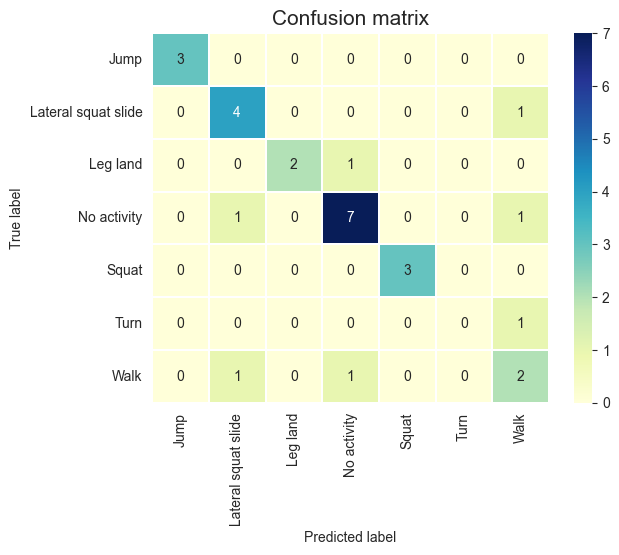

In [42]:
labels = ['Jump', 'Lateral squat slide', 'Leg land', 'No activity', 'Squat', 'Turn', 'Walk']
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt="d", cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Save the heatmap as an image locally
plt.savefig('confusion_matrix.png', bbox_inches='tight')

plt.show()